In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))
from annnet.core.graph import Graph

### Composite indexing

In [2]:

G = Graph()

G.set_vertex_key("name", "sex")

m = G.get_or_create_vertex_by_attrs(name="a", sex="man")
w = G.get_or_create_vertex_by_attrs(name="a", sex="woman")

print(m, w, m == w)   # expect two different ids, False



cid:name='a'|sex='man' cid:name='a'|sex='woman' False


In [3]:
G.set_vertex_key("name")


ValueError: Composite key conflict for ('a',): cid:name='a'|sex='man' vs cid:name='a'|sex='woman'

In [4]:
m = G.get_or_create_vertex_by_attrs(name="a", sex="man")
w = G.get_or_create_vertex_by_attrs(name="a", sex="woman")
print(m, w, m == w)   # same id, True

cid:name='a'|sex='man' cid:name='a'|sex='man' True


### Flexible directionality

In [5]:
G = Graph()
G.set_vertex_key("name","sex")

u = G.get_or_create_vertex_by_attrs(name="a", sex="man")
v = G.get_or_create_vertex_by_attrs(name="a", sex="woman")

# Helper to read signs
def signs(G, eid):
    s,t,_ = G.edge_definitions[eid]
    col = G.edge_to_idx[eid]
    si = G.entity_to_idx[s]; ti = G.entity_to_idx[t]
    M = G._matrix
    return M.get((si,col),0), M.get((ti,col),0)

# Edge-scope policy
e = G.add_edge(u, v,
    flexible={"var":"capacity", "threshold":0.7, "scope":"edge", "above":"s->t", "tie": "undirected"},
    capacity=0.5, weight=1.0)

print("init:", signs(G,e))            # expect (-1, +1)
G.set_edge_attrs(e, capacity=0.9)
print("after:", signs(G,e))           # expect (+1, -1)




init: (np.float32(-1.0), np.float32(1.0))
after: (np.float32(1.0), np.float32(-1.0))


In [6]:
# Vertex-scope policy
G2 = Graph()
G2.set_vertex_key("name","sex")
s = G2.get_or_create_vertex_by_attrs(name="a", sex="man")
t = G2.get_or_create_vertex_by_attrs(name="a", sex="woman")
G2.set_vertex_attrs(s, temp=10.0)
G2.set_vertex_attrs(t, temp=20.0)

e2 = G2.add_edge(s, t,
    flexible={"var":"temp","threshold":0.0,"scope":"vertex","above":"s->t","tie":"undirected"},
    weight=1.0)

print("xs<xt:", signs(G2,e2))         # (-1, +1)
G2.set_vertex_attrs(s, temp=25.0)
print("xs>xt:", signs(G2,e2))         # (+1, -1)
G2.set_vertex_attrs(t, temp=25.0)
print("tie  :", signs(G2,e2))         # since "tie":"undirected", it becomes: (+1, +1)

xs<xt: (np.float32(-1.0), np.float32(1.0))
xs>xt: (np.float32(1.0), np.float32(-1.0))
tie  : (np.float32(1.0), np.float32(1.0))


### Kivela Multilayers

In [7]:
# ---------- build a tiny Kivela multilayer graph ----------

G = Graph(directed=True)

# 1) Define aspects and elementary layers
G.set_aspects(
    aspects=["time"],
    elem_layers={"time": ["t1", "t2"]},
)

# 2) Add vertices in the base graph
for u in ["A", "B", "C"]:
    G.add_vertex(u, name = f"named {u}")

# 3) Declare vertex-layer presence (V_M)
for u in ["A", "B", "C"]:
    G.add_presence(u, ("t1",))
    G.add_presence(u, ("t2",))

# 4) Add Kivela edges (all go through incidence under the hood)

# intra edges in t1
G.add_intra_edge_nl("A", "B", ("t1",), weight=1.0)
G.add_intra_edge_nl("B", "C", ("t1",), weight=1.0)

# intra edges in t2
G.add_intra_edge_nl("A", "C", ("t2",), weight=2.0)

# inter-layer edge between A@t1 and B@t2
G.add_inter_edge_nl("A", ("t1",), "B", ("t2",), weight=0.5)

# coupling edges A: t1 <-> t2 and B: t1 <-> t2
G.add_coupling_edge_nl("A", ("t1",), ("t2",), weight=1.0)
G.add_coupling_edge_nl("B", ("t1",), ("t2",), weight=1.0)

# ---------- annotate layers and vertex-layer pairs ----------

# Elementary layer attributes, stored in G.layer_attributes
G.set_elementary_layer_attrs("time", "t1", order=1, name="early")
G.set_elementary_layer_attrs("time", "t2", order=2, name="late")

# vertex-layer attributes, stored in _vertex_layer_attrs
G.set_vertex_layer_attrs("A", ("t1",), activity=0.2, color="blue")
G.set_vertex_layer_attrs("A", ("t2",), activity=0.9, color="red")
G.set_vertex_layer_attrs("B", ("t1",), activity=0.5)
G.set_vertex_layer_attrs("B", ("t2",), activity=0.7)

print("vertex-layer attrs A@t1:", G.get_vertex_layer_attrs("A", ("t1",)))
print("vertex-layer attrs A@t2:", G.get_vertex_layer_attrs("A", ("t2",)))
print()

# ---------- supra structures ----------

A_supra = G.supra_adjacency()
print("Supra adjacency shape:", A_supra.shape)
print("Supra adjacency matrix:\n", A_supra.toarray())
print()

L_comb = G.supra_laplacian(kind="comb")
L_norm = G.supra_laplacian(kind="norm")
print("Combinatorial Laplacian:\n", L_comb.toarray())
print()
print("Normalized Laplacian:\n", L_norm.toarray())
print()

print("vertex-layer index (row -> (vertex, layer_tuple)):")
for i, (u, aa) in enumerate(G._row_to_nl):
    print(f"  {i}: {u} @ {aa}")
print()

deg = G.supra_degree()
print("Supra degrees per vertex-layer row:", deg)
print()

print("Participation coefficient per vertex:", G.participation_coefficient())
print("Versatility per vertex:", G.versatility())
print()

print("Layer attribute table (Polars):")
print(G.layer_attributes)


vertex-layer attrs A@t1: {'activity': 0.2, 'color': 'blue'}
vertex-layer attrs A@t2: {'activity': 0.9, 'color': 'red'}

Supra adjacency shape: (9, 9)
Supra adjacency matrix:
 [[0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  1.  0.5 0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  2. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  1.  0.  1.  0. ]
 [0.  0.5 0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  2.  0.  0.  0.  0.  0.  0. ]]

Combinatorial Laplacian:
 [[ 0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   2.5 -1.   0.  -1.  -0.5  0.   0.   0. ]
 [ 0.  -1.   3.   0.   0.   0.   0.   0.  -2. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -1.   0.   0.   3.  -1.   0.  -1.   0. ]
 [ 0.  -0.5  0.   0.  -1.   1.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0.   1.   0. ]
 [ 0.   0.  -2.   0.   0.   0.   0.   0.   2. ]]

Normalized L

In [8]:
# ---------- Kivela layer algebra & slice operations ----------

aa_t1 = ("t1",)
aa_t2 = ("t2",)

print("\n=== Kivela layer vertex/edge sets ===")
print("Vertices in layer t1:", G.layer_vertex_set(aa_t1))
print("Vertices in layer t2:", G.layer_vertex_set(aa_t2))

print("Intra edges in t1:", G.layer_edge_set(aa_t1))
print("Intra edges in t2:", G.layer_edge_set(aa_t2))

print("Edges touching t1 (intra+inter+coupling):",
      G.layer_edge_set(aa_t1, include_inter=True, include_coupling=True))
print("Edges touching t2 (intra+inter+coupling):",
      G.layer_edge_set(aa_t2, include_inter=True, include_coupling=True))

# ---------- pure Kivela layer algebra (set-based) ----------

print("\n=== Kivela layer algebra (set view) ===")
res_union = G.layer_union([aa_t1, aa_t2])
print("Union vertices (t1 ∪ t2):", res_union["vertices"])
print("Union edges   (t1 ∪ t2):", res_union["edges"])

res_inter = G.layer_intersection([aa_t1, aa_t2])
print("Intersection vertices (t1 ∩ t2):", res_inter["vertices"])
print("Intersection edges   (t1 ∩ t2):", res_inter["edges"])

res_diff = G.layer_difference(aa_t1, aa_t2)
print("Difference vertices (t1 \\ t2):", res_diff["vertices"])
print("Difference edges   (t1 \\ t2):", res_diff["edges"])

# ---------- Kivela → slice bridge ----------

print("\n=== Slice creation from Kivela layers ===")

# single-layer slices
sid_t1 = G.create_slice_from_layer("L_t1", aa_t1)
sid_t2 = G.create_slice_from_layer("L_t2", aa_t2)

print("All slices (incl. default):", G.list_slices(include_default=True))
print("Slice L_t1 vertices:", G.get_slice_vertices(sid_t1))
print("Slice L_t1 edges   :", G.get_slice_edges(sid_t1))
print("Slice L_t2 vertices:", G.get_slice_vertices(sid_t2))
print("Slice L_t2 edges   :", G.get_slice_edges(sid_t2))

# union / intersection / difference slices
sid_union = G.create_slice_from_layer_union("L_union_t1_t2", [aa_t1, aa_t2])
sid_inter = G.create_slice_from_layer_intersection("L_inter_t1_t2", [aa_t1, aa_t2])
sid_diff  = G.create_slice_from_layer_difference("L_diff_t1_t2", aa_t1, aa_t2)

print("Slice L_union_t1_t2 vertices:", G.get_slice_vertices(sid_union))
print("Slice L_union_t1_t2 edges   :", G.get_slice_edges(sid_union))

print("Slice L_inter_t1_t2 vertices:", G.get_slice_vertices(sid_inter))
print("Slice L_inter_t1_t2 edges   :", G.get_slice_edges(sid_inter))

print("Slice L_diff_t1_t2 vertices:", G.get_slice_vertices(sid_diff))
print("Slice L_diff_t1_t2 edges   :", G.get_slice_edges(sid_diff))

# ---------- Subgraphs from Kivela layers ----------

print("\n=== Subgraphs from Kivela layers ===")

Gs_t1 = G.subgraph_from_layer_tuple(aa_t1)
Gs_t2 = G.subgraph_from_layer_tuple(aa_t2)
Gs_union = G.subgraph_from_layer_union([aa_t1, aa_t2])
Gs_diff = G.subgraph_from_layer_difference(aa_t1, aa_t2)

print("Subgraph t1 vertices:", set(Gs_t1.entity_types.keys()))
print("Subgraph t1 edges   :", set(Gs_t1.edge_definitions.keys()))

print("Subgraph t2 vertices:", set(Gs_t2.entity_types.keys()))
print("Subgraph t2 edges   :", set(Gs_t2.edge_definitions.keys()))

print("Subgraph union(t1,t2) vertices:", set(Gs_union.entity_types.keys()))
print("Subgraph union(t1,t2) edges   :", set(Gs_union.edge_definitions.keys()))

print("Subgraph t1\\t2 vertices:", set(Gs_diff.entity_types.keys()))
print("Subgraph t1\\t2 edges   :", set(Gs_diff.edge_definitions.keys()))

# ---------- Optional: test LayerManager if exposed as G.layers ----------

if hasattr(G, "layers"):
    print("\n=== LayerManager high-level API ===")
    print("All layer tuples:", G.layers.layer_tuples())
    print("vertex_set(t1):", G.layers.vertex_set(aa_t1))
    print("edge_set(t1):", G.layers.edge_set(aa_t1))

    lm_union = G.layers.union([aa_t1, aa_t2])
    print("LayerManager union vertices:", lm_union["vertices"])
    print("LayerManager union edges   :", lm_union["edges"])

    lm_sid_t1 = G.layers.to_slice(aa_t1, slice_id="LM_t1")
    print("LM_t1 slice vertices:", G.get_slice_vertices(lm_sid_t1))
    print("LM_t1 slice edges   :", G.get_slice_edges(lm_sid_t1))

    Gs_lm = G.layers.subgraph(aa_t1)
    print("LayerManager subgraph(t1) vertices:", set(Gs_lm.entity_types.keys()))
    print("LayerManager subgraph(t1) edges   :", set(Gs_lm.edge_definitions.keys()))



=== Kivela layer vertex/edge sets ===
Vertices in layer t1: {'C', 'B', 'A'}
Vertices in layer t2: {'C', 'B', 'A'}
Intra edges in t1: {'A--B@t1', 'B--C@t1'}
Intra edges in t2: {'A--C@t2'}
Edges touching t1 (intra+inter+coupling): {'B--B==t1~t2', 'A--B==t1~t2', 'A--A==t1~t2', 'B--C@t1', 'A--B@t1'}
Edges touching t2 (intra+inter+coupling): {'A--B==t1~t2', 'A--A==t1~t2', 'B--B==t1~t2', 'A--C@t2'}

=== Kivela layer algebra (set view) ===
Union vertices (t1 ∪ t2): {'C', 'B', 'A'}
Union edges   (t1 ∪ t2): {'A--B@t1', 'A--C@t2', 'B--C@t1'}
Intersection vertices (t1 ∩ t2): {'C', 'B', 'A'}
Intersection edges   (t1 ∩ t2): set()
Difference vertices (t1 \ t2): set()
Difference edges   (t1 \ t2): {'A--B@t1', 'B--C@t1'}

=== Slice creation from Kivela layers ===
All slices (incl. default): ['default', 'L_t1', 'L_t2']
Slice L_t1 vertices: {'C', 'B', 'A'}
Slice L_t1 edges   : {'A--B@t1', 'B--C@t1'}
Slice L_t2 vertices: {'C', 'B', 'A'}
Slice L_t2 edges   : {'A--C@t2'}
Slice L_union_t1_t2 vertices: {'C'

### graphtool

In [9]:
import graph_tool.all as gt

In [10]:
import os
import sys

ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

from annnet.adapters import graphtool_adapter as gtt

In [11]:
gtG, manifest = gtt.to_graphtool(G)

# reconstruct an AnnNet graph:
G2 = gtt.from_graphtool(gtG, manifest)


In [12]:
gtG

<Graph object, directed, with 3 vertices and 6 edges, 1 internal vertex property, 3 internal edge properties, at 0x7968293b9fd0>

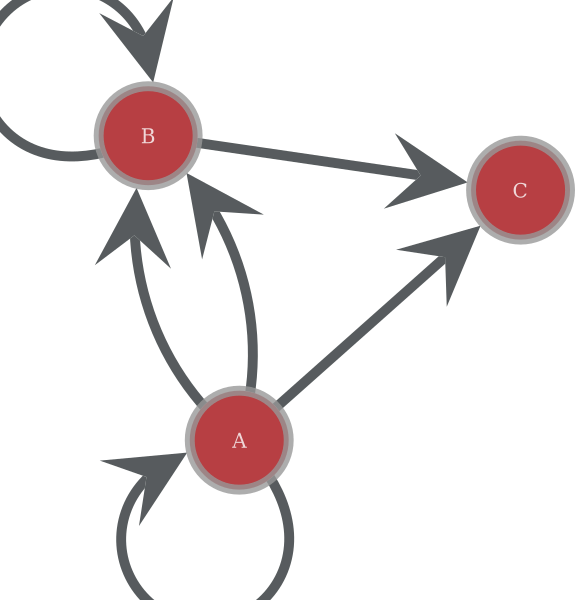

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7968293b9fd0, at 0x796828a80410>

In [13]:
pos = gt.sfdp_layout(gtG)

# Draw with vertex ids as labels
gt.graph_draw(
    gtG,
    pos=pos,
    vertex_text=gtG.vp["id"],
    vertex_font_size=10,
    output_size=(300,300),
)

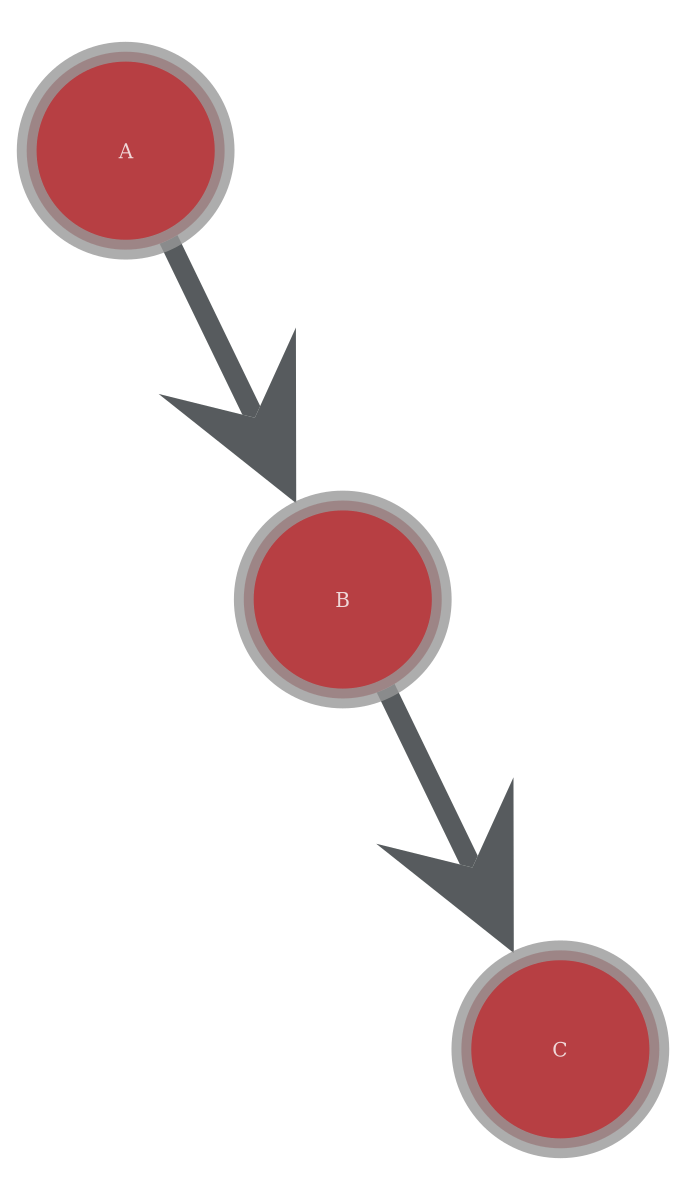

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x796828a01450, at 0x796828aa51d0>

In [14]:
# choose a layer tuple
aa = ("t1",)  # for single-aspect "time"

# subgraph of that layer
G_t1 = G.subgraph_from_layer_tuple(aa)

# project and draw
gtG_t1, man_t1 = gtt.to_graphtool(G_t1)
pos_t1 = gt.sfdp_layout(gtG_t1)
gt.graph_draw(
    gtG_t1,
    pos=pos_t1,
    vertex_text=gtG_t1.vp["id"],
    vertex_font_size=10,
    output_size=(600, 600),
)

In [15]:
manifest

{'version': 1,
 'graph': {'directed': True, 'attributes': {}},
 'vertices': {'types': {'A': 'vertex', 'B': 'vertex', 'C': 'vertex'},
  'attributes': [{'vertex_id': 'A', 'name': 'named A'},
   {'vertex_id': 'B', 'name': 'named B'},
   {'vertex_id': 'C', 'name': 'named C'}]},
 'edges': {'definitions': {'A--B@t1': ('A', 'B', 'regular'),
   'B--C@t1': ('B', 'C', 'regular'),
   'A--C@t2': ('A', 'C', 'regular'),
   'A--B==t1~t2': ('A', 'B', 'regular'),
   'A--A==t1~t2': ('A', 'A', 'regular'),
   'B--B==t1~t2': ('B', 'B', 'regular')},
  'weights': {'A--B@t1': 1.0,
   'B--C@t1': 1.0,
   'A--C@t2': 2.0,
   'A--B==t1~t2': 0.5,
   'A--A==t1~t2': 1.0,
   'B--B==t1~t2': 1.0},
  'directed': {'A--B@t1': True,
   'B--C@t1': True,
   'A--C@t2': True,
   'A--B==t1~t2': True,
   'A--A==t1~t2': True,
   'B--B==t1~t2': True},
  'direction_policy': {},
  'hyperedges': {},
  'attributes': [{'edge_id': 'A--B@t1', 'layer': 't1'},
   {'edge_id': 'B--C@t1', 'layer': 't1'},
   {'edge_id': 'A--C@t2', 'layer': 't2'

### gt lazy proxies adapter

In [16]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))
from annnet.core.graph import Graph

In [17]:
g = Graph()

In [18]:
g.add_vertex("A", age = 5)

'A'

In [19]:
g.add_vertex("B", age = 7.9)

'B'

In [20]:
g.vertex_attributes

vertex_id,age
str,f64
"""A""",5.0
"""B""",7.9


In [21]:
g.add_edge("A", "B", n = 78)

'edge_0'

In [22]:
g.add_edge("A", "B", n = 67)

'edge_1'

In [23]:
g.edge_attributes

edge_id,n
str,i64
"""edge_0""",78
"""edge_1""",67


In [24]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))
from annnet.core.graph import Graph

In [25]:
def build_simple():
    G = Graph()
    G.add_vertex("a")
    G.add_vertex("b")
    G.add_edge("a", "b", weight=5.0)
    return G

# Basic call
G = build_simple()
dist = G.gt.topology.shortest_distance(G, source="a", target="b", weights="weight")
print("distance:", float(dist))   # expected 5.0

distance: 5.0


In [26]:
# Directed
G = Graph(directed=True)
G.add_vertex("a")
G.add_vertex("b")
G.add_edge("a", "b", weight=2.0)

d1 = G.gt.topology.shortest_distance(G, source="a", target="b", weights="weight")
print("directed distance:", float(d1))  # expected 2.0

try:
    d2 = G.gt.topology.shortest_distance(G, source="b", target="a", weights="weight")
    print("reverse directed distance:", d2)
except Exception as e:
    print("reverse failed:", type(e).__name__)


directed distance: 2.0
reverse directed distance: inf


In [27]:
G = build_simple()

# Graph-tool version: must be `gtG.ep['weight']`
gtG = G.gt.backend()

# direct-graph-tool call (no proxy)
from graph_tool import topology
d_ref = topology.shortest_distance(gtG,
                                   source=gtG.vertex(0),
                                   target=gtG.vertex(1),
                                   weights=gtG.ep["weight"])

d_proxy = G.gt.topology.shortest_distance(G, source="a", target="b", weights="weight")

print("direct vs proxy:", float(d_ref), float(d_proxy))


direct vs proxy: 5.0 5.0


In [28]:
G = Graph()
G.add_vertex("x")
G.add_vertex("y")
G.add_edge("x", "y", weight=10.0)
G.add_edge("x", "y", weight=1.0)    # smallest weight should dominate shortest paths

d = G.gt.topology.shortest_distance(G, source="x", target="y", weights="weight")
print("parallel edges distance:", float(d))  # expected 1.0


parallel edges distance: 1.0


In [29]:
G = Graph()
G.add_vertex("a")
G.add_vertex("b")
G.add_vertex("c")
G.add_edge("a", "b")
G.add_edge("b", "c")

comp = G.gt.topology.label_components(G)
vp = comp[0]  # vertex property map

print("component of a:", int(vp[G.gt.backend().vertex(0)]))
print("component of c:", int(vp[G.gt.backend().vertex(2)]))


component of a: 2
component of c: 0


In [30]:
G = Graph()
G.add_vertex("a")
G.add_vertex("b")
G.add_vertex("c")
G.add_edge("a", "b")
G.add_edge("b", "c")

vc, ec = G.gt.centrality.betweenness(G)

print("betweenness(a) =", float(vc[G.gt.backend().vertex(0)]))
print("betweenness(b) =", float(vc[G.gt.backend().vertex(1)]))
print("betweenness(c) =", float(vc[G.gt.backend().vertex(2)]))


betweenness(a) = 0.0
betweenness(b) = 0.5
betweenness(c) = 0.0


In [31]:
dmap = G.gt.topology.shortest_distance(G, source="a", weights="weight")
print("distance map entry b:", float(dmap[G.gt.backend().vertex(1)]))


distance map entry b: 1.0


In [32]:
G = build_simple()

try:
    G.gt.topology.shortest_distance(G, source="zzz", target="a", weights="weight")
except Exception as e:
    print("Caught error:", type(e).__name__, str(e))


Caught error: ValueError Unknown vertex label 'zzz' (label field 'None')


In [33]:
g= G

In [34]:
g.V

('a', 'b')

In [35]:
g.vertex_attributes

vertex_id
str
"""a"""
"""b"""


In [36]:
g.add_vertex("v", name = 67)

'v'

In [37]:
g.vertex_attributes

vertex_id,name
str,i64
"""a""",null
"""b""",null
"""v""",67


In [38]:
g.set_vertex_attrs("v", a = 8)

In [39]:
g.vertex_attributes

vertex_id,name,a
str,i64,i64
"""a""",null,null
"""b""",null,null
"""v""",67,8


In [40]:
g.E

('edge_0',)

In [41]:
g.set_edge_attrs("edge_0", age = 78)

In [42]:
g.edge_attributes

edge_id,age
str,i64
"""edge_0""",78


In [43]:
g.set_vertex_attrs("v", name = 8888)

In [44]:
g.vertex_attributes

vertex_id,name,a
str,i64,i64
"""a""",null,null
"""b""",null,null
"""v""",8888,8


In [45]:
g.set_vertex_attrs("tt")

In [46]:
g.vertex_attributes

vertex_id,name,a
str,i64,i64
"""a""",null,null
"""b""",null,null
"""v""",8888,8


### CX2 adapter

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))
from annnet.core.graph import Graph
from annnet.adapters import cx2_adapter as cx

In [2]:
from annnet.io import io_annnet as ia



In [3]:
G = ia.read("ppi.annnet")

In [4]:
G.vertex_attributes

vertex_id,family,kind,role
str,str,str,str
"""P1""","""kinase""",null,null
"""P2""","""kinase""",null,null
"""P3""","""kinase""",null,null
"""P4""","""kinase""",null,null
"""P5""","""kinase""",null,null
…,…,…,…
"""edge_rxn_8""",null,null,"""enzyme"""
"""edge_rxn_9""",null,null,"""enzyme"""
"""edge_rxn_10""",null,null,"""enzyme"""


In [5]:
sk = cx.to_cx2(G)

ex = cx.to_cx2(G, hyperedges= "expand")

rf = cx.to_cx2(G, hyperedges= "reify")

In [6]:
import json

# Assuming 'cx2_data' is the variable holding your list of dictionaries
output_file = "sk.cx2"

with open(output_file, "w") as f:
    json.dump(sk, f)

print(f"Saved to {output_file}")

Saved to sk.cx2


In [7]:
import json

# Assuming 'cx2_data' is the variable holding your list of dictionaries
output_file = "ex.cx2"

with open(output_file, "w") as f:
    json.dump(ex, f)

print(f"Saved to {output_file}")

Saved to ex.cx2


In [8]:
import json

# Assuming 'cx2_data' is the variable holding your list of dictionaries
output_file = "rf.cx2"

with open(output_file, "w") as f:
    json.dump(rf, f)

print(f"Saved to {output_file}")

Saved to rf.cx2


In [9]:
def build_simple():
    G = Graph()
    G.add_vertex("a")
    G.add_vertex("b")
    G.add_edge("a", "b", weight=5.0)
    G.add_hyperedge(members=["A","C","D"], weight=1.0, tag="complex")
    G.add_hyperedge(head=["A","B"], tail=["C","D"], weight=1.0, reaction="A+B->C+D")
    return G

# Basic call
Gs = build_simple()
ts = cx.to_cx2(Gs, hyperedges= "reify")

In [10]:
import json

# Assuming 'cx2_data' is the variable holding your list of dictionaries
output_file = "ts.cx2"

with open(output_file, "w") as f:
    json.dump(ts, f)

print(f"Saved to {output_file}")

Saved to ts.cx2


In [11]:
tsg= cx.from_cx2('ts.cx2')

tsg.edges_view()

edge_id,kind,directed,global_weight,source,target,edge_type,head,tail,members,role,tag,reaction,effective_weight
str,str,bool,f64,str,str,str,list[str],list[str],list[str],str,str,str,f64
"""edge_0""","""binary""",true,5.0,"""a""","""b""","""regular""",null,null,null,null,null,null,5.0
"""edge_1::member""","""binary""",true,1.0,"""A""","""hyperedge::edge_1""","""regular""",null,null,null,"""member""",null,null,1.0
"""edge_2::tail""","""binary""",true,1.0,"""C""","""hyperedge::edge_2""","""regular""",null,null,null,"""tail""",null,null,1.0
"""edge_2::head""","""binary""",true,1.0,"""hyperedge::edge_2""","""A""","""regular""",null,null,null,"""head""",null,null,1.0


In [12]:
skg= cx.from_cx2('sk.cx2')


In [13]:
exg = cx.from_cx2('ex.cx2')

In [18]:
rfg = cx.from_cx2("rf.cx2")

In [20]:
skg.vertex_attributes

kind,role,vertex_id,family
str,str,str,str
null,null,"""P1""","""kinase"""
null,null,"""P2""","""kinase"""
null,null,"""P3""","""kinase"""
null,null,"""P4""","""kinase"""
null,null,"""P5""","""kinase"""
…,…,…,…
null,"""enzyme""","""edge_rxn_8""",null
null,"""enzyme""","""edge_rxn_9""",null
null,"""enzyme""","""edge_rxn_10""",null
